# Controlling Cameras
In this example we will walk through how to control the main camera, take screenshots, and demonstrate the multiple camera functionality.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/VirtualBrainLab/urchin-examples/blob/main/basics/cameras.ipynb)

## Install Urchin

Urchin is a Python package stored on PyPI, the following code needs to be run the first time you use Urchin in a Python environment. 

Urchin's full documentation can be found [on our website](https://virtualbrainlab.org/urchin/installation_and_use.html).

In [ ]:
#Installing urchin
!pip install oursin -U

## Setup Urchin and open the renderer webpage 

By default Urchin opens the 3D renderer in a webpage. Make sure pop-ups are enabled, or the page won't open properly. You can also open the renderer site yourself by replacing [ID here] with the ID that is output by the call to `.setup()` at https://data.virtualbrainlab.org/Urchin/?ID=[ID here]

Note that Urchin communicates to the renderer webpage through an internet connection, we don't currently support offline use (we hope to add support in the future).

In [2]:
#Importing necessary libraries:
import pandas as pd
from PIL import Image
import oursin as urchin
urchin.setup()

(URN) connected to server
Login sent with ID: e849aefe, copy this ID into the renderer to connect.


For this tutorial we'll use data from Jordan Shaker in the Steinmetz Lab, collected from recordings targeting the MRN.

In [3]:
# To pull in data to a dataframe:
data = urchin.io.load_df("https://drive.google.com/file/d/1RDwe2Je2AufvrAExe5RdJL-JLbeP93NQ/view?usp=drive_link")

## Setup a basic scene
Let's make the root brain area visible, as well as a few brain regions so that we can see what we're doing when we control the main camera.

In [4]:
urchin.ccf25.load()

In [5]:
urchin.ccf25.grey.set_visibility(True)
urchin.ccf25.grey.set_material('transparent-unlit')
urchin.ccf25.grey.set_alpha(0.1)

In [6]:
brain_areas = ["MRN", "SCs", "SCm", "APN", "RN"]
#Generating brain area images:
area_list = urchin.ccf25.get_areas(brain_areas)

urchin.ccf25.set_visibilities(area_list, True)
urchin.ccf25.set_materials(area_list, 'transparent-unlit')
urchin.ccf25.set_alphas(area_list, 0.2)

## Controlling the main camera
The main `Camera` is always accessible to you through `urchin.camera.main`. You can use this object to rotate, zoom, and control the background color.

A quick note about rotations. Because we rotate around three axes in order we are doing something called an Euler rotation (first around y, then, z, then x, or first around DV, then, AP, then ML). This type of rotation is subject to *gimbal lock*, which basically means that if you rotate 90 degrees around one axis you sometimes lose a degree of freedom and the other two axes start causing the same rotation. This can be... very confusing. Just know that all rotations are possible, but it can take some trial and error to figure out how to get the camera to rotate the way you want it!

In [7]:
urchin.camera.main.set_rotation([22.5, 22.5, 225])
urchin.camera.main.set_mode('perspective')
urchin.camera.main.set_zoom(45)
urchin.camera.main.set_background_color('#000000')

(Camera receive) Camera CameraMain received an image
(Camera receive) CameraMain complete


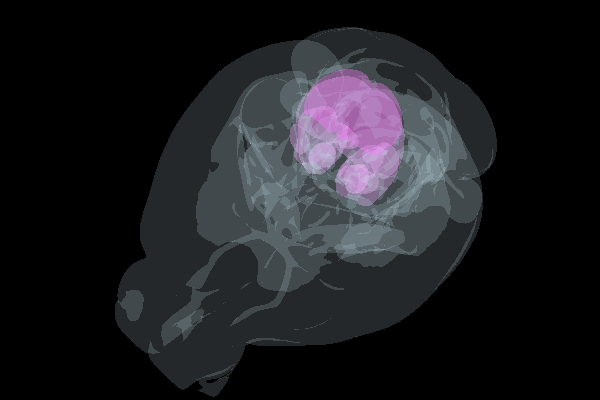

In [8]:
await urchin.camera.main.screenshot(size=[600,400])

## Add some data
Let's display some neurons to make the scene a little more interesting. Thanks Jordan!

In [9]:
data.head()

,x,y,z,file,labels,color
0,3854.099849,8700.0,3185.198183,JRS_00042021-06-16_AudiocoordArray.csv,Audio,#F6D55C
1,3854.099849,8700.0,3185.198183,JRS_00042021-06-16_AudiocoordArrayFiltered.csv,Audio,#F6D55C
2,3956.855249,8725.0,3788.986745,JRS_00042021-06-16_LickscoordArray.csv,Licks,#ED553B
3,3950.491288,8725.0,3744.439018,JRS_00042021-06-16_LickscoordArray.csv,Licks,#ED553B
4,3935.642046,8725.0,3640.494321,JRS_00042021-06-16_LickscoordArray.csv,Licks,#ED553B


In [10]:
urchin.particles.clear()

In [11]:
#Creating neurons
num_neurons = len(data)
neurons = urchin.particles.create(num_neurons)

#Setting neuron colors
urchin.particles.set_colors(neurons,list(data.loc[:,"color"]))

#Setting neuron positions
#putting in proper formating:
neuron_positions = []
for i, row in data.iterrows():
    ap = row['y']/1000
    ml = row['x']/1000
    dv = row['z']/1000
    neuron_positions.append([ap, ml, dv])
#Setting position:
urchin.particles.set_positions(neurons, neuron_positions)

(Camera receive) Camera CameraMain received an image
(Camera receive) CameraMain complete


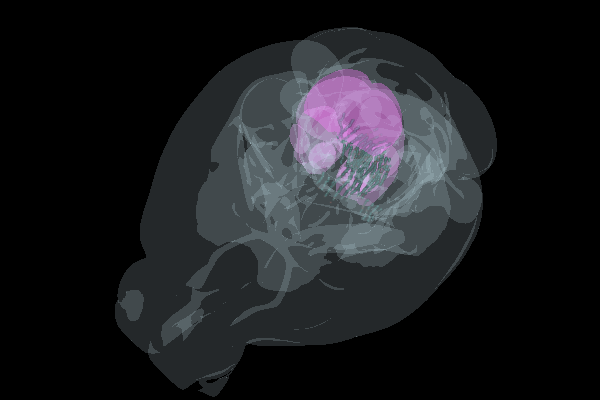

In [12]:
await urchin.camera.main.screenshot(size=[600,400])

## Controlling multiple camera views
You might want to use Urchin to create a scene and then take images of it from multiple angles, e.g. for a publication. The most common use case is probably rendering axial, sagittal, coronal, and an "angled" view (like the one in the screenshot above).

To do this, we'll need to create additional `Camera` objects and set their rotation and zoom settings.

In [13]:
# Create three additional cameras
a_cam = urchin.camera.Camera()
s_cam = urchin.camera.Camera()
c_cam = urchin.camera.Camera()

### Setting up the "standard" scene
Let's set up the standard scene where we have three cameras looking from axial, sagittal, and coronal, and the main camera in the angled view. We'll have to adjust the zoom a little bit for each camera as well.

Note that because the side views are orthogonal views it's actually best to keep the cameras in `orthographic` mode. The angled view though will look warped unless you set it to `perspective` mode.

In [25]:
a_cam.set_rotation('axial')
a_cam.set_zoom(7)
a_cam.set_background_color('#000000')

s_cam.set_rotation('sagittal')
s_cam.set_zoom(7)
s_cam.set_background_color('#000000')

c_cam.set_rotation('coronal')
c_cam.set_zoom(6)
c_cam.set_background_color('#000000')

Now we can get an image from all four cameras!

In [27]:
angled_png = await urchin.camera.main.screenshot(size=[300,200])
axial_png = await a_cam.screenshot(size=[300,200])
sagittal_png = await s_cam.screenshot(size=[300,200])
coronal_png = await c_cam.screenshot(size=[300,200])

(Camera receive) Camera CameraMain received an image
(Camera receive) CameraMain complete
(Camera receive) Camera Camera1 received an image
(Camera receive) Camera1 complete
(Camera receive) Camera Camera2 received an image
(Camera receive) Camera2 complete
(Camera receive) Camera Camera3 received an image
(Camera receive) Camera3 complete


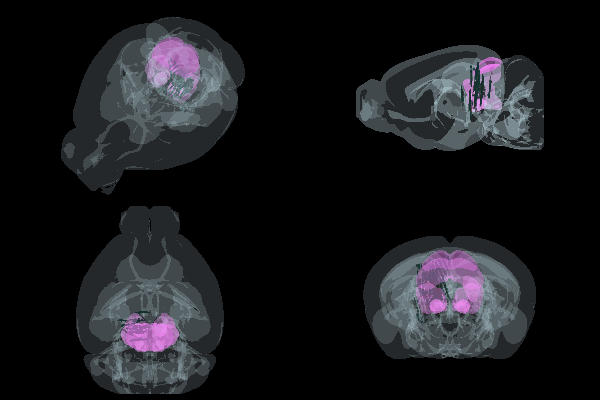

In [29]:
grid_image = Image.new('RGBA', (600, 400))

grid_image.paste(angled_png, (0, 0))
grid_image.paste(sagittal_png, (300, 0))
grid_image.paste(axial_png, (0, 200))
grid_image.paste(coronal_png, (300, 200))

grid_image

### Targetting specific areas (Feature not working in 0.5.0)


### Mouse control
To control the secondary cameras with the mouse by clicking and dragging, you can call `Camera.set_controllable()`. Now you can use the mouse to set up your preferred angles and zoom. Remember that you can hold [SPACE] while dragging the mouse to rotate around the DV (Y) axis.

In [30]:
a_cam.set_controllable()